<a href="https://colab.research.google.com/github/pr-shukla/MS-Thesis/blob/main/multi_dqn_pur_evad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import gym
import math
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:

#Time Difference Between 2 Steps
dt = 0.4


#Minimum turing radius of Pursuer
rho = 0.3

#velocity of pursuer
v = 1.0


#Velocity of Evader during training
ve = 0.5

#angle between initial velocity and reference
te = 3*np.pi/4

num_agents = 2

In [ ]:
EPISODES = 1000

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='selu'))
        model.add(Dense(24, activation='selu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def memorize(self, state, action, rew, next_state):
        self.memory.append((state, action, rew, next_state))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        acti = np.argmax(act_values[0])
        #print(float(acti))
        return np.argmax(act_values[0]) # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, rew, next_state in minibatch:
            target = rew
            target = (rew + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
#Function for generating sigmoid output of Input Function
def sigmoid(x):
    val = 1/(1+np.exp(-x))
    return val

#Calculating Distance between Pursuer and Evader
def L(rx1, ry1, rx2, ry2):
    d = np.sqrt((rx2-rx1)**2 + (ry2-ry1)**2)
    return d

#Calculating angle between velocity and reference axis
def thetap(state):
    v = 1.0
    angle = math.acos(state[2]/v)*((state[3]+0.001)/abs(state[3]+0.001))-np.pi*((state[3]+0.0001)/(abs(state[3])+0.0001)-1)
    return angle

def alph(state):
    l = L(state)
    angle = math.acos((state[4]-state[0])/l)*(state[5]-state[1]+0.0001)/abs(state[5]-state[1]+0.0001)-(np.pi)*(((state[5]-state[1]+0.0001)/abs(0.0001+state[5]-state[1]))-1)
    return angle

#Reward Calculator
def reward(state):
  rewards = []
  for i in range(num_agents):
    '''
    ag_state = []
    for j in state[i*4:(i+1)*4]:
      ag_state.append(j)
    for j in ev_state:
      ag_state.append(j)
    '''

    r1 = 10*np.exp(-3*state[0+i*3])
    r2 = 10*np.exp(-1*state[1+i*3])
    r3 = 5*np.arctan(1*state[2+i*3])
    r4 = 5*np.exp(-3*state[2+i*3])
    r5 = 10*np.exp(-1*state[0+i*3]*state[2+i*3])
    r =  r1 + r4 #+ r2  #+ r3 
    
    rewards.append(r)

  return sum(rewards)

#Calculator of Angle between velocity and line joining Evader and Pursuer
def phi(rx1, ry1, vx1, vy1, rx2, ry2):
    d = L(rx1, ry1, rx2, ry2)
    rx2_rx1 = rx2 - rx1
    ry2_ry1 = ry2 - ry1
    angle = math.acos(round((rx2_rx1*vx1+ ry2_ry1*vy1)/d, 4))
    return angle

In [ ]:
import random
class environment:
  def __init__(self):
    self.p1_rx = random.uniform(0.0, -10.0)
    self.p1_ry = random.uniform(0.0, -10.0)
    self.p2_rx = random.uniform(10.0, 20.0)
    self.p2_ry = random.uniform(10.0, 20.0)
    self.p1_vx = 1.0
    self.p1_vy = 0.0
    self.p2_vx = 1.0
    self.p2_vy = 0.0
    self.e_rx = 5.0
    self.e_ry = 5.0
    self.e_vx = ve*np.cos(te)
    self.e_vy = ve*np.sin(te)
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                   self.p1_ry]
    state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                   self.p1_ry]
    return state_p1_e, state_p2_e
    

  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    return obs

  def state_step(self, actions):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    theta_v_p1 = thetap(state_p1_e)
    theta_v_p2 = thetap(state_p2_e)

    

    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_p2 = self.p2_vx * dt
    del_ry_p2 = self.p2_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (1.0/rho)*((actions//3)-1)/1.0*dt
    del_theta_v_p2 = (1.0/rho)*((actions%3)-1)/1.0*dt

    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    theta_v_p2 = theta_v_p2 + del_theta_v_p2

    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = 1.0 * np.cos(theta_v_p1)
    self.p1_vy = 1.0 * np.sin(theta_v_p1)

    self.p2_rx = self.p2_rx + del_rx_p2
    self.p2_ry = self.p2_ry + del_ry_p2
    self.p2_vx = 1.0 * np.cos(theta_v_p2)
    self.p2_vy = 1.0 * np.sin(theta_v_p2)

    self.e_rx = self.e_rx + del_rx_e
    self.e_ry = self.e_ry + del_ry_e

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]

    return state_p1_e, state_p2_e

  def step(self, actions):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    old_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    
    state_p1_e, state_p2_e = self.state_step(actions)

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)

    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    new_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]

    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt),
           d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]
    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    
    return obs

In [ ]:
state_size = 6
action_size = 9
agent = DQNAgent(state_size, action_size)

Current Episode: 1 Current Time Step: 0
Current Episode: 1 Current Time Step: 25
Current Episode: 1 Current Time Step: 50
Current Episode: 1 Current Time Step: 75
Current Episode: 1 Current Time Step: 100
Current Episode: 1 Current Time Step: 125
Current Episode: 1 Current Time Step: 150
Current Episode: 1 Current Time Step: 175
Episode * 1 * Avg Reward is ==> 826.3392526727927


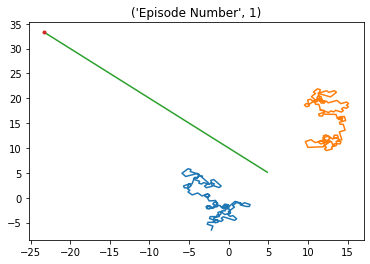

Current Episode: 2 Current Time Step: 0
Current Episode: 2 Current Time Step: 25
Current Episode: 2 Current Time Step: 50
Current Episode: 2 Current Time Step: 75
Current Episode: 2 Current Time Step: 100
Current Episode: 2 Current Time Step: 125
Current Episode: 2 Current Time Step: 150
Current Episode: 2 Current Time Step: 175
Episode * 2 * Avg Reward is ==> 621.992104660555


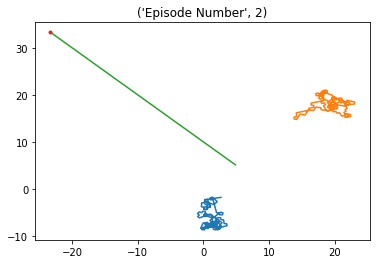

Current Episode: 3 Current Time Step: 0
Current Episode: 3 Current Time Step: 25
Current Episode: 3 Current Time Step: 50
Current Episode: 3 Current Time Step: 75
Current Episode: 3 Current Time Step: 100
Current Episode: 3 Current Time Step: 125
Current Episode: 3 Current Time Step: 150
Current Episode: 3 Current Time Step: 175
Episode * 3 * Avg Reward is ==> 555.1141462287716


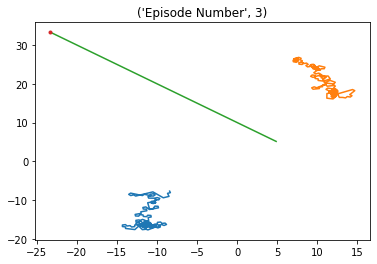

Current Episode: 4 Current Time Step: 0
Current Episode: 4 Current Time Step: 25
Current Episode: 4 Current Time Step: 50
Current Episode: 4 Current Time Step: 75
Current Episode: 4 Current Time Step: 100
Current Episode: 4 Current Time Step: 125
Current Episode: 4 Current Time Step: 150
Current Episode: 4 Current Time Step: 175
Episode * 4 * Avg Reward is ==> 651.1660489407401


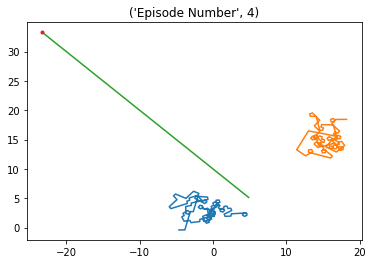

Current Episode: 5 Current Time Step: 0
Current Episode: 5 Current Time Step: 25
Current Episode: 5 Current Time Step: 50
Current Episode: 5 Current Time Step: 75
Current Episode: 5 Current Time Step: 100
Current Episode: 5 Current Time Step: 125
Current Episode: 5 Current Time Step: 150
Current Episode: 5 Current Time Step: 175
Episode * 5 * Avg Reward is ==> 693.4477436314517


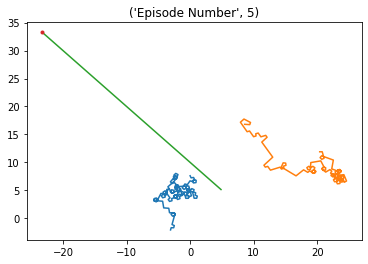

Current Episode: 6 Current Time Step: 0
Current Episode: 6 Current Time Step: 25
Current Episode: 6 Current Time Step: 50
Current Episode: 6 Current Time Step: 75
Current Episode: 6 Current Time Step: 100
Current Episode: 6 Current Time Step: 125
Current Episode: 6 Current Time Step: 150
Current Episode: 6 Current Time Step: 175
Episode * 6 * Avg Reward is ==> 663.9866398113626


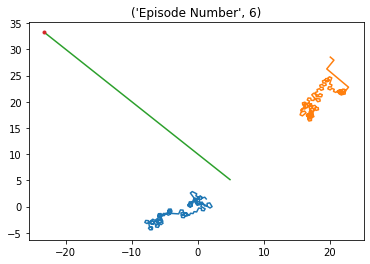

Current Episode: 7 Current Time Step: 0
Current Episode: 7 Current Time Step: 25
Current Episode: 7 Current Time Step: 50
Current Episode: 7 Current Time Step: 75
Current Episode: 7 Current Time Step: 100
Current Episode: 7 Current Time Step: 125
Current Episode: 7 Current Time Step: 150
Current Episode: 7 Current Time Step: 175
Episode * 7 * Avg Reward is ==> 622.0021658097627


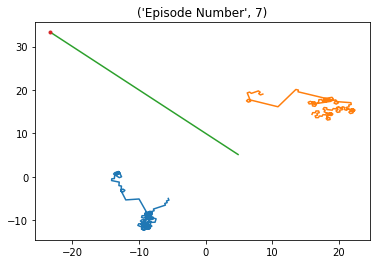

Current Episode: 8 Current Time Step: 0
Current Episode: 8 Current Time Step: 25
Current Episode: 8 Current Time Step: 50
Current Episode: 8 Current Time Step: 75
Current Episode: 8 Current Time Step: 100
Current Episode: 8 Current Time Step: 125
Current Episode: 8 Current Time Step: 150
Current Episode: 8 Current Time Step: 175
Episode * 8 * Avg Reward is ==> 732.2996768302346


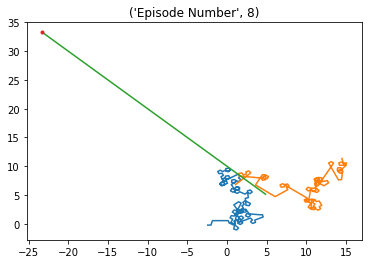

Current Episode: 9 Current Time Step: 0
Current Episode: 9 Current Time Step: 25
Current Episode: 9 Current Time Step: 50
Current Episode: 9 Current Time Step: 75
Current Episode: 9 Current Time Step: 100
Current Episode: 9 Current Time Step: 125
Current Episode: 9 Current Time Step: 150
Current Episode: 9 Current Time Step: 175
Episode * 9 * Avg Reward is ==> 757.8587452473664


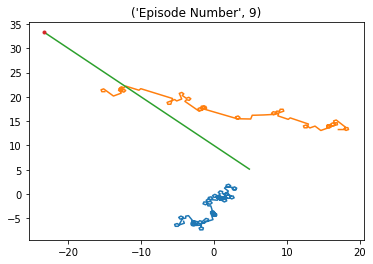

Current Episode: 10 Current Time Step: 0
Current Episode: 10 Current Time Step: 25
Current Episode: 10 Current Time Step: 50
Current Episode: 10 Current Time Step: 75
Current Episode: 10 Current Time Step: 100
Current Episode: 10 Current Time Step: 125
Current Episode: 10 Current Time Step: 150
Current Episode: 10 Current Time Step: 175
Episode * 10 * Avg Reward is ==> 878.0963411324149


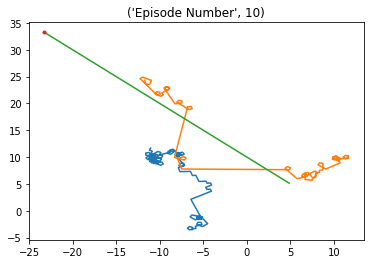

Current Episode: 11 Current Time Step: 0
Current Episode: 11 Current Time Step: 25
Current Episode: 11 Current Time Step: 50
Current Episode: 11 Current Time Step: 75
Current Episode: 11 Current Time Step: 100
Current Episode: 11 Current Time Step: 125
Current Episode: 11 Current Time Step: 150
Current Episode: 11 Current Time Step: 175
Episode * 11 * Avg Reward is ==> 875.9135451573658


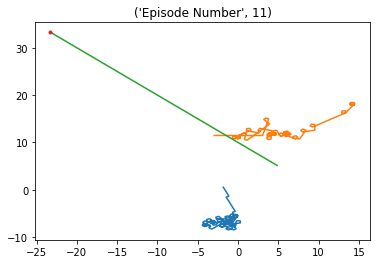

Current Episode: 12 Current Time Step: 0
Current Episode: 12 Current Time Step: 25
Current Episode: 12 Current Time Step: 50
Current Episode: 12 Current Time Step: 75
Current Episode: 12 Current Time Step: 100
Current Episode: 12 Current Time Step: 125
Current Episode: 12 Current Time Step: 150
Current Episode: 12 Current Time Step: 175
Episode * 12 * Avg Reward is ==> 911.555127166588


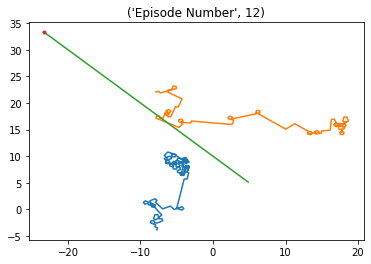

Current Episode: 13 Current Time Step: 0
Current Episode: 13 Current Time Step: 25
Current Episode: 13 Current Time Step: 50
Current Episode: 13 Current Time Step: 75
Current Episode: 13 Current Time Step: 100
Current Episode: 13 Current Time Step: 125
Current Episode: 13 Current Time Step: 150
Current Episode: 13 Current Time Step: 175
Episode * 13 * Avg Reward is ==> 981.3577915246299


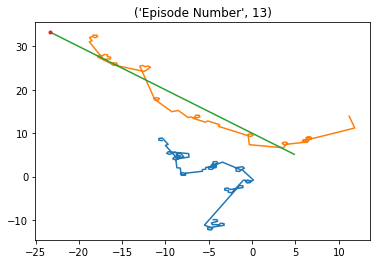

Current Episode: 14 Current Time Step: 0
Current Episode: 14 Current Time Step: 25
Current Episode: 14 Current Time Step: 50
Current Episode: 14 Current Time Step: 75
Current Episode: 14 Current Time Step: 100
Current Episode: 14 Current Time Step: 125
Current Episode: 14 Current Time Step: 150
Current Episode: 14 Current Time Step: 175
Episode * 14 * Avg Reward is ==> 1057.0970829429305


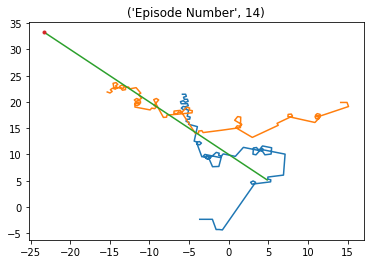

Current Episode: 15 Current Time Step: 0
Current Episode: 15 Current Time Step: 25
Current Episode: 15 Current Time Step: 50
Current Episode: 15 Current Time Step: 75
Current Episode: 15 Current Time Step: 100
Current Episode: 15 Current Time Step: 125
Current Episode: 15 Current Time Step: 150
Current Episode: 15 Current Time Step: 175
Episode * 15 * Avg Reward is ==> 1168.3355365157172


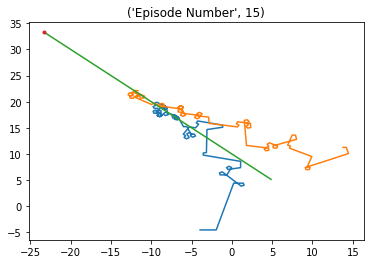

Current Episode: 16 Current Time Step: 0
Current Episode: 16 Current Time Step: 25
Current Episode: 16 Current Time Step: 50
Current Episode: 16 Current Time Step: 75
Current Episode: 16 Current Time Step: 100
Current Episode: 16 Current Time Step: 125
Current Episode: 16 Current Time Step: 150
Current Episode: 16 Current Time Step: 175
Episode * 16 * Avg Reward is ==> 1262.2563268145725


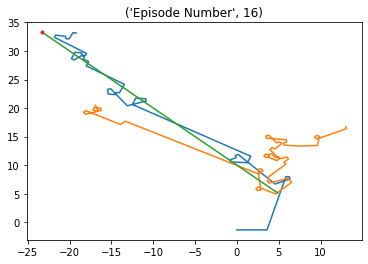

Current Episode: 17 Current Time Step: 0
Current Episode: 17 Current Time Step: 25
Current Episode: 17 Current Time Step: 50
Current Episode: 17 Current Time Step: 75
Current Episode: 17 Current Time Step: 100
Current Episode: 17 Current Time Step: 125
Current Episode: 17 Current Time Step: 150
Current Episode: 17 Current Time Step: 175
Episode * 17 * Avg Reward is ==> 1317.796834700259


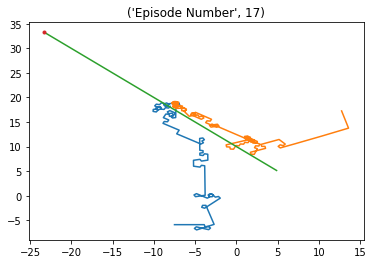

Current Episode: 18 Current Time Step: 0
Current Episode: 18 Current Time Step: 25
Current Episode: 18 Current Time Step: 50
Current Episode: 18 Current Time Step: 75
Current Episode: 18 Current Time Step: 100
Current Episode: 18 Current Time Step: 125
Current Episode: 18 Current Time Step: 150
Current Episode: 18 Current Time Step: 175
Episode * 18 * Avg Reward is ==> 1426.6923334445512


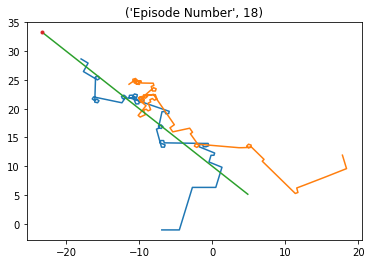

Current Episode: 19 Current Time Step: 0
Current Episode: 19 Current Time Step: 25
Current Episode: 19 Current Time Step: 50
Current Episode: 19 Current Time Step: 75
Current Episode: 19 Current Time Step: 100
Current Episode: 19 Current Time Step: 125
Current Episode: 19 Current Time Step: 150
Current Episode: 19 Current Time Step: 175
Episode * 19 * Avg Reward is ==> 1511.02022240995


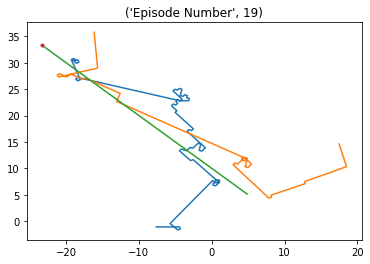

Current Episode: 20 Current Time Step: 0
Current Episode: 20 Current Time Step: 25
Current Episode: 20 Current Time Step: 50
Current Episode: 20 Current Time Step: 75
Current Episode: 20 Current Time Step: 100
Current Episode: 20 Current Time Step: 125
Current Episode: 20 Current Time Step: 150
Current Episode: 20 Current Time Step: 175
Episode * 20 * Avg Reward is ==> 1593.9051651684981


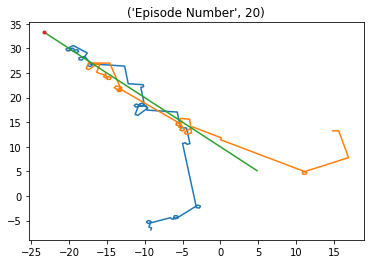

Current Episode: 21 Current Time Step: 0
Current Episode: 21 Current Time Step: 25
Current Episode: 21 Current Time Step: 50
Current Episode: 21 Current Time Step: 75
Current Episode: 21 Current Time Step: 100
Current Episode: 21 Current Time Step: 125
Current Episode: 21 Current Time Step: 150


KeyboardInterrupt: ignored

In [ ]:


ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []



# agent.load("./save/cartpole-dqn.h5")

batch_size = 32

#print(state_size, action_size)

for e in range(EPISODES):
    env = environment()
    prev_state = env.initial_obs()


    episodic_reward = 0
    ag1_reward = 0
    
    xp1 = []
    yp1 = []
    xp2 = []
    yp2 = []
    xce = []
    yce = []


    prev_state = np.reshape(prev_state, [1, state_size])
    for time in range(200):
        # env.render()
        action = agent.act(prev_state)
        #print(action)

        next_state = env.step(action)
        #print(next_state)
        rew = reward(next_state)
        
        #next_state, reward, done, _ = env.step(action)
        #rew = rew #if not done else -10
        #print(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        agent.memorize(prev_state, action, rew, next_state)
        prev_state = next_state
        #print(action)
        
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

        episodic_reward += rew
        #print(rew)
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)

        xp2.append(env.p2_rx)
        yp2.append(env.p2_ry)

        xce.append(env.e_rx)
        yce.append(env.e_ry)

        if time%25 ==0:
            print('Current Episode:', e+1, 'Current Time Step:', time)

    xc1 = [env.e_rx]
    yc1 = [env.e_ry]
    ep_reward_list.append(episodic_reward)

    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)

    print("Episode * {} * Avg Reward is ==> {}".format(e+1, avg_reward))

    plt.plot(xp1,yp1)
    plt.plot(xp2,yp2)
    plt.plot(xce,yce)
    plt.plot(xc1,yc1,'.')
    title = 'Episode Number', e+1
    plt.title(title)
    plt.show()



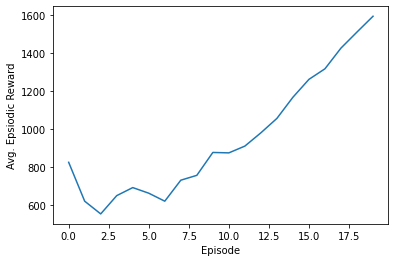

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.plot(avg_reward_list)

Current Episode: 1 Current Time Step: 0
Current Episode: 1 Current Time Step: 25
Current Episode: 1 Current Time Step: 50
Captured
Episode * 1 * Avg Reward is ==> 1162.5506362931376


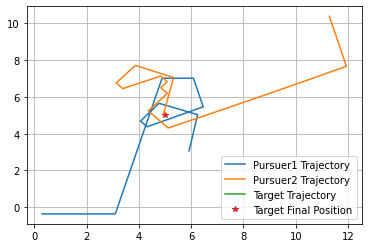

In [ ]:
import random
ve = 0.0
te = 3*np.pi/4
dt = 0.4

class environment:
  def __init__(self):
    self.p1_rx = random.uniform(0.0, -1.0)
    self.p1_ry = random.uniform(0.0, -1.0)
    self.p2_rx = random.uniform(10.0, 11.0)
    self.p2_ry = random.uniform(10.0, 11.0)
    self.p1_vx = 1.0
    self.p1_vy = 0.0
    self.p2_vx = 1.0
    self.p2_vy = 0.0
    self.e_rx = 5.0
    self.e_ry = 5.0
    self.e_vx = ve*np.cos(te)
    self.e_vy = ve*np.sin(te)
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                   self.p1_ry]
    state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                   self.p1_ry]
    return state_p1_e, state_p2_e
    

  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    return obs

  def state_step(self, actions):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    theta_v_p1 = thetap(state_p1_e)
    theta_v_p2 = thetap(state_p2_e)

    

    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_p2 = self.p2_vx * dt
    del_ry_p2 = self.p2_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (1.0/rho)*((actions//3)-1)/1.0*dt
    del_theta_v_p2 = (1.0/rho)*((actions%3)-1)/1.0*dt

    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    theta_v_p2 = theta_v_p2 + del_theta_v_p2

    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = 1.0 * np.cos(theta_v_p1)
    self.p1_vy = 1.0 * np.sin(theta_v_p1)

    self.p2_rx = self.p2_rx + del_rx_p2
    self.p2_ry = self.p2_ry + del_ry_p2
    self.p2_vx = 1.0 * np.cos(theta_v_p2)
    self.p2_vy = 1.0 * np.sin(theta_v_p2)

    self.e_rx = self.e_rx + del_rx_e
    self.e_ry = self.e_ry + del_ry_e

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]

    return state_p1_e, state_p2_e

  def step(self, actions):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    old_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    
    state_p1_e, state_p2_e = self.state_step(actions)

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)

    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    new_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]

    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt),
           d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]
    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    
    return obs



ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []



# agent.load("./save/cartpole-dqn.h5")

batch_size = 32

#print(state_size, action_size)

for e in range(1):
    env = environment()
    prev_state = env.initial_obs()


    episodic_reward = 0
    ag1_reward = 0
    
    xp1 = []
    yp1 = []
    xp2 = []
    yp2 = []
    xce = []
    yce = []


    prev_state = np.reshape(prev_state, [1, state_size])
    for time in range(400):
        # env.render()
        action = agent.act(prev_state)
        #print(action)

        next_state = env.step(action)
        #print(next_state)
        rew = reward(next_state)
        
        #next_state, reward, done, _ = env.step(action)
        #rew = rew #if not done else -10
        #print(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        prev_state = next_state
        #print(action)
        
        

        episodic_reward += rew
        #print(rew)
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)

        xp2.append(env.p2_rx)
        yp2.append(env.p2_ry)

        xce.append(env.e_rx)
        yce.append(env.e_ry)

        if time%25 ==0:
            print('Current Episode:', e+1, 'Current Time Step:', time)
        d_p1_e = L(env.p1_rx, env.p1_ry, env.e_rx, env.e_ry)
        d_p2_e = L(env.p2_rx, env.p2_ry, env.e_rx, env.e_ry)

        if d_p1_e < 0.2 or d_p2_e < 0.2:
          #env = environment()
          #prev_state = env.initial_obs()
          print("Captured")
          break

    xc1 = [env.e_rx]
    yc1 = [env.e_ry]
    ep_reward_list.append(episodic_reward)

    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)

    print("Episode * {} * Avg Reward is ==> {}".format(e+1, avg_reward))

    plt.plot(xp1,yp1, label = 'Pursuer1 Trajectory')
    plt.plot(xp2,yp2, label = 'Pursuer2 Trajectory')
    plt.plot(xce,yce, label = 'Target Trajectory')
    plt.plot(xc1,yc1,'*', label = 'Target Final Position')
    plt.legend()
    plt.grid()
    plt.show()
    


  

Current Episode: 1 Current Time Step: 0
Current Episode: 1 Current Time Step: 25
Current Episode: 1 Current Time Step: 50
Current Episode: 1 Current Time Step: 75
Current Episode: 1 Current Time Step: 100
Current Episode: 1 Current Time Step: 125
Current Episode: 1 Current Time Step: 150
Current Episode: 1 Current Time Step: 175
Episode * 1 * Avg Reward is ==> 2539.3861338039687


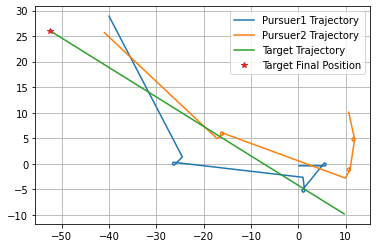

In [ ]:
import random
ve = 0.9
te = 5*np.pi/6
dt = 0.4

class environment:
  def __init__(self):
    self.p1_rx = random.uniform(0.0, -1.0)
    self.p1_ry = random.uniform(0.0, -1.0)
    self.p2_rx = random.uniform(10.0, 11.0)
    self.p2_ry = random.uniform(10.0, 11.0)
    self.p1_vx = 1.0
    self.p1_vy = 0.0
    self.p2_vx = 1.0
    self.p2_vy = 0.0
    self.e_rx = 10.0
    self.e_ry = -10.0
    self.e_vx = ve*np.cos(te)
    self.e_vy = ve*np.sin(te)
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                   self.p1_ry]
    state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                   self.p1_ry]
    return state_p1_e, state_p2_e
    

  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    return obs

  def state_step(self, actions):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    theta_v_p1 = thetap(state_p1_e)
    theta_v_p2 = thetap(state_p2_e)

    

    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_p2 = self.p2_vx * dt
    del_ry_p2 = self.p2_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (1.0/rho)*((actions//3)-1)/1.0*dt
    del_theta_v_p2 = (1.0/rho)*((actions%3)-1)/1.0*dt

    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    theta_v_p2 = theta_v_p2 + del_theta_v_p2

    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = 1.0 * np.cos(theta_v_p1)
    self.p1_vy = 1.0 * np.sin(theta_v_p1)

    self.p2_rx = self.p2_rx + del_rx_p2
    self.p2_ry = self.p2_ry + del_ry_p2
    self.p2_vx = 1.0 * np.cos(theta_v_p2)
    self.p2_vy = 1.0 * np.sin(theta_v_p2)

    self.e_rx = self.e_rx + del_rx_e
    self.e_ry = self.e_ry + del_ry_e

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]

    return state_p1_e, state_p2_e

  def step(self, actions):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    old_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    
    state_p1_e, state_p2_e = self.state_step(actions)

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)

    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    new_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]

    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt),
           d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]
    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    
    return obs



ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []



# agent.load("./save/cartpole-dqn.h5")

batch_size = 32

#print(state_size, action_size)

for e in range(1):
    env = environment()
    prev_state = env.initial_obs()


    episodic_reward = 0
    ag1_reward = 0
    
    xp1 = []
    yp1 = []
    xp2 = []
    yp2 = []
    xce = []
    yce = []


    prev_state = np.reshape(prev_state, [1, state_size])
    for time in range(200):
        # env.render()
        action = agent.act(prev_state)
        #print(action)

        next_state = env.step(action)
        #print(next_state)
        rew = reward(next_state)
        
        #next_state, reward, done, _ = env.step(action)
        #rew = rew #if not done else -10
        #print(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        prev_state = next_state
        #print(action)
        
        

        episodic_reward += rew
        #print(rew)
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)

        xp2.append(env.p2_rx)
        yp2.append(env.p2_ry)

        xce.append(env.e_rx)
        yce.append(env.e_ry)

        if time%25 ==0:
            print('Current Episode:', e+1, 'Current Time Step:', time)

        d_p1_e = L(env.p1_rx, env.p1_ry, env.e_rx, env.e_ry)
        d_p2_e = L(env.p2_rx, env.p2_ry, env.e_rx, env.e_ry)

        if d_p1_e < 0.2 or d_p2_e < 0.2:
          #env = environment()
          #prev_state = env.initial_obs()
          print("Captured")
          break

    xc1 = [env.e_rx]
    yc1 = [env.e_ry]
    ep_reward_list.append(episodic_reward)

    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)

    print("Episode * {} * Avg Reward is ==> {}".format(e+1, avg_reward))

    plt.plot(xp1,yp1, label = 'Pursuer1 Trajectory')
    plt.plot(xp2,yp2, label = 'Pursuer2 Trajectory')
    plt.plot(xce,yce, label = 'Target Trajectory')
    plt.plot(xc1,yc1,'*', label = 'Target Final Position')
    plt.legend()
    plt.grid()
    plt.show()
    

  

Current Episode: 1 Current Time Step: 0
Current Episode: 1 Current Time Step: 25
Current Episode: 1 Current Time Step: 50
Current Episode: 1 Current Time Step: 75
Current Episode: 1 Current Time Step: 100
Current Episode: 1 Current Time Step: 125
Current Episode: 1 Current Time Step: 150
Current Episode: 1 Current Time Step: 175
Episode * 1 * Avg Reward is ==> 2584.3579496678553


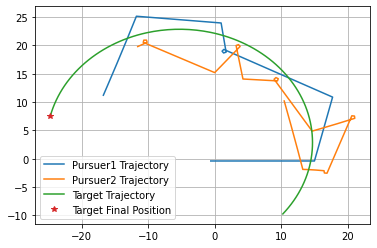

In [ ]:
import random
ve = 0.9
te = np.pi/4
rho_e = 2.0
dt = 0.4

class environment:
  def __init__(self):
    self.p1_rx = random.uniform(0.0, -1.0)
    self.p1_ry = random.uniform(0.0, -1.0)
    self.p2_rx = random.uniform(10.0, 11.0)
    self.p2_ry = random.uniform(10.0, 11.0)
    self.p1_vx = 1.0
    self.p1_vy = 0.0
    self.p2_vx = 1.0
    self.p2_vy = 0.0
    self.e_rx = +10.0
    self.e_ry = -10.0
    self.e_vx = ve*np.cos(te)
    self.e_vy = ve*np.sin(te)
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                   self.p1_ry]
    state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                   self.p1_ry]
    return state_p1_e, state_p2_e
    

  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    return obs

  def state_step(self, actions, theta_v_e):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]

    
    theta_v_p1 = thetap(state_p1_e)
    theta_v_p2 = thetap(state_p2_e)

    

    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_p2 = self.p2_vx * dt
    del_ry_p2 = self.p2_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (1.0/rho)*((actions//3)-1)/1.0*dt
    del_theta_v_p2 = (1.0/rho)*((actions%3)-1)/1.0*dt
    del_theta_v_e  = (ve/rho_e)*0.1*dt

    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    theta_v_p2 = theta_v_p2 + del_theta_v_p2
    theta_v_e  = theta_v_e  + del_theta_v_e

    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = 1.0 * np.cos(theta_v_p1)
    self.p1_vy = 1.0 * np.sin(theta_v_p1)

    self.p2_rx = self.p2_rx + del_rx_p2
    self.p2_ry = self.p2_ry + del_ry_p2
    self.p2_vx = 1.0 * np.cos(theta_v_p2)
    self.p2_vy = 1.0 * np.sin(theta_v_p2)

    self.e_rx = self.e_rx + del_rx_e
    self.e_ry = self.e_ry + del_ry_e
    self.e_vx = ve * np.cos(theta_v_e)
    self.e_vy = ve * np.sin(theta_v_e)

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]

    return state_p1_e, state_p2_e, theta_v_e

  def step(self, actions, theta_v_e):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    old_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    
    state_p1_e, state_p2_e, theta_v_e = self.state_step(actions, theta_v_e)

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)

    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    new_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]

    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt),
           d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]
    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    
    return obs, theta_v_e



ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []



# agent.load("./save/cartpole-dqn.h5")

batch_size = 32

#print(state_size, action_size)

for e in range(1):
    env = environment()
    prev_state = env.initial_obs()


    episodic_reward = 0
    ag1_reward = 0
    
    xp1 = []
    yp1 = []
    xp2 = []
    yp2 = []
    xce = []
    yce = []


    prev_state = np.reshape(prev_state, [1, state_size])

    state_e_p1 = [env.e_rx, env.e_ry, env.e_vx, env.e_vy,
                  env.p1_rx, env.p1_ry]

    theta_v_e  = thetap(state_e_p1)

    for time in range(200):
        # env.render()
        action = agent.act(prev_state)
        #print(action)

        next_state, theta_v_e = env.step(action, theta_v_e)
        #print(next_state)
        rew = reward(next_state)
        
        #next_state, reward, done, _ = env.step(action)
        #rew = rew #if not done else -10
        #print(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        prev_state = next_state
        #print(action)
        
        

        episodic_reward += rew
        #print(rew)
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)

        xp2.append(env.p2_rx)
        yp2.append(env.p2_ry)

        xce.append(env.e_rx)
        yce.append(env.e_ry)

        if time%25 ==0:
            print('Current Episode:', e+1, 'Current Time Step:', time)

        d_p1_e = L(env.p1_rx, env.p1_ry, env.e_rx, env.e_ry)
        d_p2_e = L(env.p2_rx, env.p2_ry, env.e_rx, env.e_ry)

        if d_p1_e < 0.2 or d_p2_e < 0.2:
          #env = environment()
          #prev_state = env.initial_obs()
          print("Captured")
          break

    xc1 = [env.e_rx]
    yc1 = [env.e_ry]
    ep_reward_list.append(episodic_reward)

    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)

    print("Episode * {} * Avg Reward is ==> {}".format(e+1, avg_reward))

    plt.plot(xp1,yp1, label = 'Pursuer1 Trajectory')
    plt.plot(xp2,yp2, label = 'Pursuer2 Trajectory')
    plt.plot(xce,yce, label = 'Target Trajectory')
    plt.plot(xc1,yc1,'*', label = 'Target Final Position')
    plt.legend()
    plt.grid()
    plt.show()

  

Current Episode: 1 Current Time Step: 0
Current Episode: 1 Current Time Step: 25
Current Episode: 1 Current Time Step: 50
Episode * 1 * Avg Reward is ==> 931.679102353447


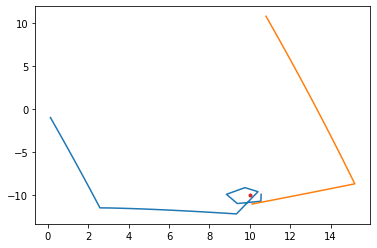

In [ ]:
import random
ve = 0.0
te = 5*np.pi/6
dt = 0.4

class environment:
  def __init__(self):
    self.p1_rx = random.uniform(0.0, -1.0)
    self.p1_ry = random.uniform(0.0, -1.0)
    self.p2_rx = random.uniform(10.0, 11.0)
    self.p2_ry = random.uniform(10.0, 11.0)
    self.p1_vx = 1.0
    self.p1_vy = 0.0
    self.p2_vx = 1.0
    self.p2_vy = 0.0
    self.e_rx = +10.0
    self.e_ry = -10.0
    self.e_vx = ve*np.cos(te)
    self.e_vy = ve*np.sin(te)
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                   self.p1_ry]
    state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                   self.p1_ry]
    return state_p1_e, state_p2_e
    

  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    return obs

  def state_step(self, actions):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    theta_v_p1 = thetap(state_p1_e)
    theta_v_p2 = thetap(state_p2_e)

    

    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_p2 = self.p2_vx * dt
    del_ry_p2 = self.p2_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (1.0/rho)*((actions//3)-1)/1.0*dt
    del_theta_v_p2 = (1.0/rho)*((actions%3)-1)/1.0*dt

    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    theta_v_p2 = theta_v_p2 + del_theta_v_p2

    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = 1.0 * np.cos(theta_v_p1)
    self.p1_vy = 1.0 * np.sin(theta_v_p1)

    self.p2_rx = self.p2_rx + del_rx_p2
    self.p2_ry = self.p2_ry + del_ry_p2
    self.p2_vx = 1.0 * np.cos(theta_v_p2)
    self.p2_vy = 1.0 * np.sin(theta_v_p2)

    self.e_rx = self.e_rx + del_rx_e
    self.e_ry = self.e_ry + del_ry_e

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]

    return state_p1_e, state_p2_e

  def step(self, actions):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    old_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    
    state_p1_e, state_p2_e = self.state_step(actions)

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)

    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    new_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]

    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt),
           d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]
    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    
    return obs



ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []



# agent.load("./save/cartpole-dqn.h5")

batch_size = 32

#print(state_size, action_size)

for e in range(1):
    env = environment()
    prev_state = env.initial_obs()


    episodic_reward = 0
    ag1_reward = 0
    
    xp1 = []
    yp1 = []
    xp2 = []
    yp2 = []
    xce = []
    yce = []


    prev_state = np.reshape(prev_state, [1, state_size])
    for time in range(65):
        # env.render()
        action = agent.act(prev_state)
        #print(action)

        next_state = env.step(action)
        #print(next_state)
        rew = reward(next_state)
        
        #next_state, reward, done, _ = env.step(action)
        #rew = rew #if not done else -10
        #print(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        prev_state = next_state
        #print(action)
        
        

        episodic_reward += rew
        #print(rew)
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)

        xp2.append(env.p2_rx)
        yp2.append(env.p2_ry)

        xce.append(env.e_rx)
        yce.append(env.e_ry)

        if time%25 ==0:
            print('Current Episode:', e+1, 'Current Time Step:', time)

    xc1 = [env.e_rx]
    yc1 = [env.e_ry]
    ep_reward_list.append(episodic_reward)

    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)

    print("Episode * {} * Avg Reward is ==> {}".format(e+1, avg_reward))

    plt.plot(xp1,yp1)
    plt.plot(xp2,yp2)
    plt.plot(xce,yce)
    plt.plot(xc1,yc1,'.')
    
    plt.show()


  

Current Episode: 1 Current Time Step: 0
Current Episode: 1 Current Time Step: 25
Current Episode: 1 Current Time Step: 50
Current Episode: 1 Current Time Step: 75
Current Episode: 1 Current Time Step: 100
Current Episode: 1 Current Time Step: 125
Current Episode: 1 Current Time Step: 150
Current Episode: 1 Current Time Step: 175
Current Episode: 1 Current Time Step: 200
Current Episode: 1 Current Time Step: 225
Episode * 1 * Avg Reward is ==> 5285.4549537205985


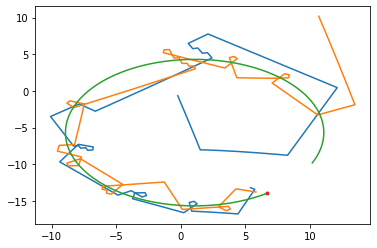

In [ ]:
import random
ve = 0.6
te = np.pi/4
rho_e = 10.0
dt = 0.4

class environment:
  def __init__(self):
    self.p1_rx = random.uniform(0.0, -1.0)
    self.p1_ry = random.uniform(0.0, -1.0)
    self.p2_rx = random.uniform(10.0, 11.0)
    self.p2_ry = random.uniform(10.0, 11.0)
    self.p1_vx = 1.0
    self.p1_vy = 0.0
    self.p2_vx = 1.0
    self.p2_vy = 0.0
    self.e_rx = +10.0
    self.e_ry = -10.0
    self.e_vx = ve*np.cos(te)
    self.e_vy = ve*np.sin(te)
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                   self.p1_ry]
    state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                   self.p1_ry]
    return state_p1_e, state_p2_e
    

  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    return obs

  def state_step(self, actions, theta_v_e):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]

    
    theta_v_p1 = thetap(state_p1_e)
    theta_v_p2 = thetap(state_p2_e)

    

    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_p2 = self.p2_vx * dt
    del_ry_p2 = self.p2_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (1.0/rho)*((actions//3)-1)/1.0*dt
    del_theta_v_p2 = (1.0/rho)*((actions%3)-1)/1.0*dt
    del_theta_v_e  = (ve/rho_e)*1.0*dt

    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    theta_v_p2 = theta_v_p2 + del_theta_v_p2
    theta_v_e  = theta_v_e  + del_theta_v_e

    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = 1.0 * np.cos(theta_v_p1)
    self.p1_vy = 1.0 * np.sin(theta_v_p1)

    self.p2_rx = self.p2_rx + del_rx_p2
    self.p2_ry = self.p2_ry + del_ry_p2
    self.p2_vx = 1.0 * np.cos(theta_v_p2)
    self.p2_vy = 1.0 * np.sin(theta_v_p2)

    self.e_rx = self.e_rx + del_rx_e
    self.e_ry = self.e_ry + del_ry_e
    self.e_vx = ve * np.cos(theta_v_e)
    self.e_vy = ve * np.sin(theta_v_e)

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]

    return state_p1_e, state_p2_e, theta_v_e

  def step(self, actions, theta_v_e):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    old_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    
    state_p1_e, state_p2_e, theta_v_e = self.state_step(actions, theta_v_e)

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)

    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    new_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]

    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt),
           d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]
    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    
    return obs, theta_v_e



ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []



# agent.load("./save/cartpole-dqn.h5")

batch_size = 32

#print(state_size, action_size)

for e in range(1):
    env = environment()
    prev_state = env.initial_obs()


    episodic_reward = 0
    ag1_reward = 0
    
    xp1 = []
    yp1 = []
    xp2 = []
    yp2 = []
    xce = []
    yce = []


    prev_state = np.reshape(prev_state, [1, state_size])

    state_e_p1 = [env.e_rx, env.e_ry, env.e_vx, env.e_vy,
                  env.p1_rx, env.p1_ry]

    theta_v_e  = thetap(state_e_p1)

    for time in range(240):
        # env.render()
        action = agent.act(prev_state)
        #print(action)

        next_state, theta_v_e = env.step(action, theta_v_e)
        #print(next_state)
        rew = reward(next_state)
        
        #next_state, reward, done, _ = env.step(action)
        #rew = rew #if not done else -10
        #print(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        prev_state = next_state
        #print(action)
        
        

        episodic_reward += rew
        #print(rew)
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)

        xp2.append(env.p2_rx)
        yp2.append(env.p2_ry)

        xce.append(env.e_rx)
        yce.append(env.e_ry)

        if time%25 ==0:
            print('Current Episode:', e+1, 'Current Time Step:', time)

    xc1 = [env.e_rx]
    yc1 = [env.e_ry]
    ep_reward_list.append(episodic_reward)

    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)

    print("Episode * {} * Avg Reward is ==> {}".format(e+1, avg_reward))

    plt.plot(xp1,yp1)
    plt.plot(xp2,yp2)
    plt.plot(xce,yce)
    plt.plot(xc1,yc1,'.')
    
    plt.show()


  